In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import signal
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_roi, plot_stat_map,plot_epi, plot_img
from nilearn.image import new_img_like
import nilearn as nl 
import nibabel as nib
from nilearn import datasets
from sklearn.decomposition import PCA
import bids
import os
import glob
from nltools import Brain_Data
import seaborn as sns


# Homemade functions

In [2]:
def fit_mask_get_mean(current_mask, sub_data):
    try:
        fit_2_mask = current_mask.fit_transform(sub_data)
        mean_score = np.mean(fit_2_mask)
    except ValueError:
        mean_score = 0
    return mean_score

# Open Hassen Neurotransmitters Maps

In [3]:
# Now open a directory/folder 
fd = os.open("/Users/luisalvarez/Documents", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents


### Dopamine Maps

In [4]:
# Define paths to Hassen files for dopamine neurotransmitters. 
path_D1 = "GitHub/hansen_receptors/data/PET_nifti_images/D1_SCH23390_hc13_kaller.nii"
path_D2_smith = "GitHub/hansen_receptors/data/PET_nifti_images/D2_flb457_hc37_smith.nii.gz"
path_D2_sandiego = "GitHub/hansen_receptors/data/PET_nifti_images/D2_flb457_hc55_sandiego.nii.gz"
path_DAT = "GitHub/hansen_receptors/data/PET_nifti_images/DAT_fpcit_hc174_dukart_spect.nii"

# Create Brain_data objects for each file. 
D1_map = Brain_Data(path_D1).to_nifti()
D2_smith_map = Brain_Data(path_D2_smith).to_nifti()
D2_sandiego_map = Brain_Data(path_D2_sandiego).to_nifti()
DAT_map = Brain_Data(path_DAT).to_nifti()

# Check the shape of each file.
print("D1_map shape: " + str(D1_map.shape))
print("D2_smith_map shape: " + str(D2_smith_map.shape))
print("D2_sandiego_map shape: " + str(D2_sandiego_map.shape))
print("DAT_map shape: " + str(DAT_map.shape))


D1_map shape: (91, 109, 91)
D2_smith_map shape: (91, 109, 91)
D2_sandiego_map shape: (91, 109, 91)
DAT_map shape: (91, 109, 91)


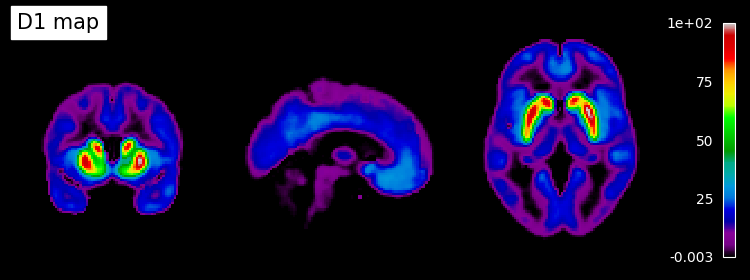

In [5]:
# Visualize the D1 map.
plot_epi(D1_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="D1 map")


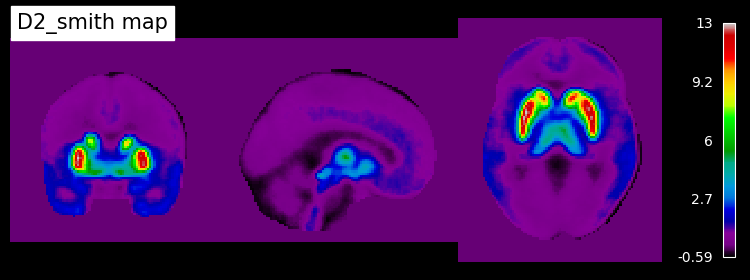

In [6]:
# Visualize the D2_smith map.
plot_epi(D2_smith_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="D2_smith map")


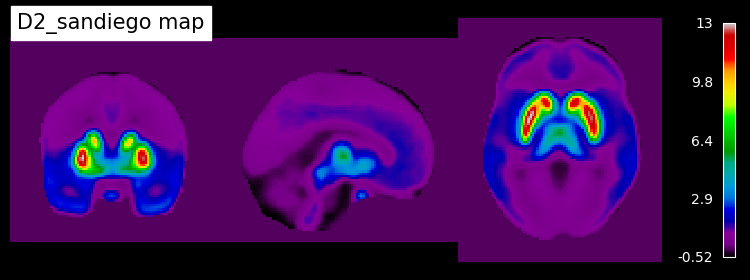

In [7]:
# Visualize the D2_sandiego map.
plot_epi(D2_sandiego_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="D2_sandiego map")


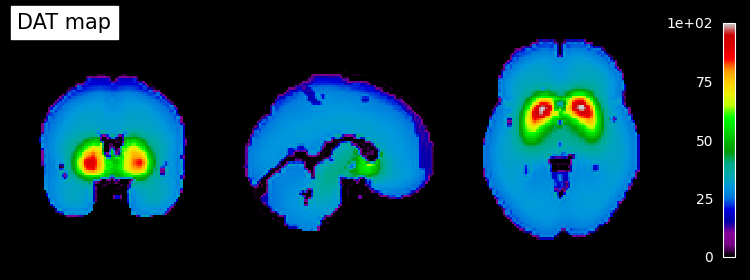

In [8]:
# Visualize the DAT map.
plot_epi(DAT_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="DAT map")

### Norepinephrine Maps

In [9]:
# Define paths to Hassen files for norepinephrine neurotransmitters. 
path_NAT = "GitHub/hansen_receptors/data/PET_nifti_images/NAT_MRB_hc77_ding.nii.gz"

# Create Brain_data objects for each file. 
NAT_map = Brain_Data(path_NAT).to_nifti()

# Check the shape of each file.
print("NAT_map shape: " + str(NAT_map.shape))

NAT_map shape: (91, 109, 91)


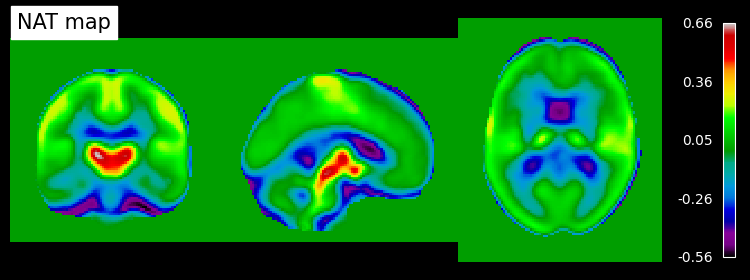

In [10]:
# Visualize the NAT map.
plot_epi(NAT_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="NAT map")

### Glutamate Maps

In [11]:
# Define paths to Hassen files for dopamine neurotransmitters. 
path_mGlu = "GitHub/hansen_receptors/data/PET_nifti_images/mGluR5_abp_hc73_smart.nii"
path_NMDA = "GitHub/hansen_receptors/data/PET_nifti_images/NMDA_ge179_hc29_galovic.nii.gz"

# Create Brain_data objects for each file. 
mGlu_map = Brain_Data(path_mGlu).to_nifti()
NMDA_map = Brain_Data(path_NMDA).to_nifti()

# Check the shape of each file.
print("mGlu_map shape: " + str(mGlu_map.shape))
print("NMDA_map shape: " + str(NMDA_map.shape))


mGlu_map shape: (91, 109, 91)
NMDA_map shape: (91, 109, 91)


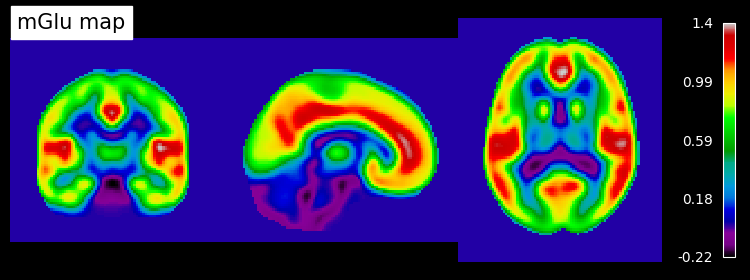

In [12]:
# Visualize the mGlu map.
plot_epi(mGlu_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="mGlu map")

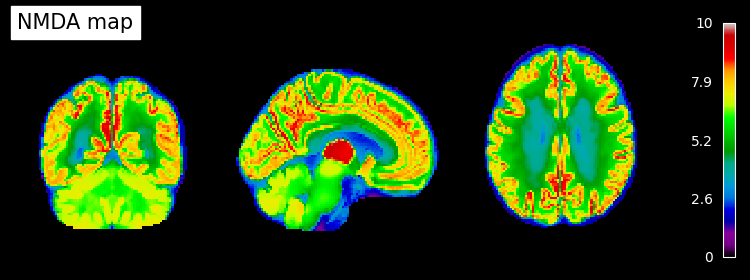

In [13]:
# Visualize the NMDA map.
plot_epi(NMDA_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="NMDA map")

### GABA Maps

In [14]:
# Define paths to Hassen files for GABA neurotransmitters. 
path_GABAa = "GitHub/hansen_receptors/data/PET_nifti_images/GABAa_flumazenil_hc6_dukart.nii"
path_GABAbz = "GitHub/hansen_receptors/data/PET_nifti_images/GABAa-bz_flumazenil_hc16_norgaard.nii"

# Create Brain_data objects for each file. 
GABAa_map = Brain_Data(path_GABAa).to_nifti()
GABAbz_map = Brain_Data(path_GABAbz).to_nifti()

# Check the shape of each file.
print("GABAa shape: " + str(GABAa_map.shape))
print("GABAbz shape: " + str(GABAbz_map.shape))

GABAa shape: (91, 109, 91)
GABAbz shape: (91, 109, 91)


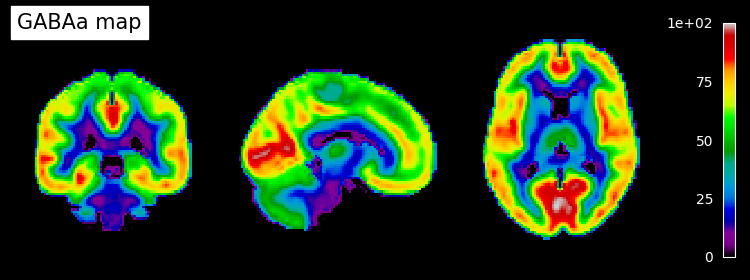

In [15]:
# Visualize the GABAa map.
plot_epi(GABAa_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="GABAa map")

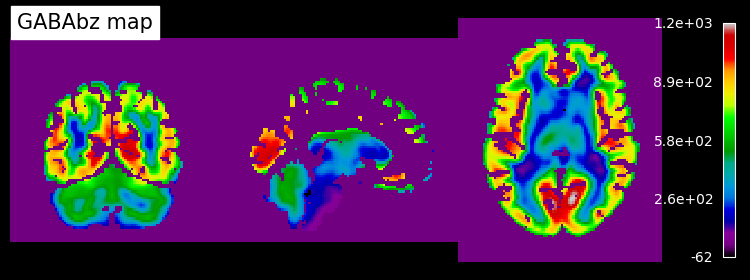

In [16]:
# Visualize the GABAbz map.
plot_epi(GABAbz_map, draw_cross=False, annotate=False, black_bg=True, colorbar=True, title="GABAbz map")

## Display AA Results

In [39]:
# Get AAL COC-PLA change scores csv file. 
Change_PC1_AA_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAL_COCPLA_Change_PC1_scores.csv', index_col=0) 

# Calculate mean change score for each region.
Change_PC1_AA_mean_scores = []

for x in range(len(AA_labels)):
    Change_PC1_AA_mean_scores.append(Change_PC1_AA_scores_df[AA_labels[x]].mean(skipna=True))

In [ ]:
# Show top 5 ROIs with most positive change score.



In [ ]:
# Show top 5 ROIs with most negative change score.



## Compare Neurotransmitter Densities to AA map 

In [38]:
# Load the AAL atlas from nilearn.
AA = datasets.fetch_atlas_aal()

# Store atlas info.
AA_maps = AA.maps 

AA_labels = AA.labels

AA_indices = AA.indices

print("AA_labels: " + str(AA_labels))
print("AA_indices: " + str(AA_indices))

AA_labels: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusif

In [18]:
# Compute a mask for each parcel in the AAL atlas. 
aal_roi_masks = []

for x in range(116):
    
    print("Computing and plotting roi_" +str(x) +": " + str(AA_labels[x]))
    roi_img =nl.image.new_img_like(AA_maps, nl.image.get_data(AA_maps) == int(AA_indices[x]))
    masker = NiftiMasker(mask_img=roi_img, verbose=False).fit()
    aal_roi_masks.append(masker)
    

Computing and plotting roi_0: Precentral_L
Computing and plotting roi_1: Precentral_R
Computing and plotting roi_2: Frontal_Sup_L
Computing and plotting roi_3: Frontal_Sup_R
Computing and plotting roi_4: Frontal_Sup_Orb_L
Computing and plotting roi_5: Frontal_Sup_Orb_R
Computing and plotting roi_6: Frontal_Mid_L
Computing and plotting roi_7: Frontal_Mid_R
Computing and plotting roi_8: Frontal_Mid_Orb_L
Computing and plotting roi_9: Frontal_Mid_Orb_R
Computing and plotting roi_10: Frontal_Inf_Oper_L
Computing and plotting roi_11: Frontal_Inf_Oper_R
Computing and plotting roi_12: Frontal_Inf_Tri_L
Computing and plotting roi_13: Frontal_Inf_Tri_R
Computing and plotting roi_14: Frontal_Inf_Orb_L
Computing and plotting roi_15: Frontal_Inf_Orb_R
Computing and plotting roi_16: Rolandic_Oper_L
Computing and plotting roi_17: Rolandic_Oper_R
Computing and plotting roi_18: Supp_Motor_Area_L
Computing and plotting roi_19: Supp_Motor_Area_R
Computing and plotting roi_20: Olfactory_L
Computing and p

In [19]:
# Fit AAL to Hassen Neurotransmitters maps. 

D1_to_AAL_mean_scores = []
D2_smith_to_AAL_mean_scores = []
D2_sd_to_AAL_mean_scores = []
DAT_to_AAL_mean_scores = []
NAT_to_AAL_mean_scores = []
mGlu_to_AAL_mean_scores = []
NMDA_to_AAL_mean_scores = []
GABAa_to_AAL_mean_scores = []
GABAbz_to_AAL_mean_scores = []

for current_roi in range(116):

    D1_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], D1_map))
    D2_smith_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], D2_smith_map))
    D2_sd_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], D2_sandiego_map))
    DAT_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], DAT_map))
    NAT_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], NAT_map))
    mGlu_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], mGlu_map))
    NMDA_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], NMDA_map))
    GABAa_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], GABAa_map))
    GABAbz_to_AAL_mean_scores.append(fit_mask_get_mean(aal_roi_masks[current_roi], GABAbz_map))
    




In [30]:
from scipy.stats import pearsonr 

# Compute correlation between Hassen maps and AAL PC1 scores 
D1_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, D1_to_AAL_mean_scores)
D2_smith_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, D2_smith_to_AAL_mean_scores)
D2_sd_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, D2_sd_to_AAL_mean_scores)
DAT_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, DAT_to_AAL_mean_scores)

NAT_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, NAT_to_AAL_mean_scores)
mGlu_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, mGlu_to_AAL_mean_scores)
NMDA_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, NMDA_to_AAL_mean_scores)
GABAa_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, GABAa_to_AAL_mean_scores)
GABAbz_AAl_cor = pearsonr(Change_PC1_AA_mean_scores, GABAbz_to_AAL_mean_scores)

print("Correlation between D1 map and AAL PC1 scores: r=%3f, p-value=%3f" % (D1_AAl_cor[0], D1_AAl_cor[1])) 
print("Correlation between D2_smith map and AAL PC1 scores: r=%3f, p-value=%3f" % (D2_smith_AAl_cor[0], D2_smith_AAl_cor[1])) 
print("Correlation between D2_sd and AAL PC1 scores: r=%3f, p-value=%3f" % (D2_sd_AAl_cor[0], D2_sd_AAl_cor[1])) 
print("Correlation between DAT map and AAL PC1 scores: r=%3f, p-value=%3f" % (DAT_AAl_cor[0], DAT_AAl_cor[1])) 

print("Correlation between NAT map and AAL PC1 scores: r=%3f, p-value=%3f" % (NAT_AAl_cor[0], NAT_AAl_cor[1])) 
print("Correlation between mGlu map and AAL PC1 scores: r=%3f, p-value=%3f" % (mGlu_AAl_cor[0], mGlu_AAl_cor[1])) 
print("Correlation between NMDA map and AAL PC1 scores: r=%3f, p-value=%3f" % (NMDA_AAl_cor[0], NMDA_AAl_cor[1])) 
print("Correlation between GABAa map and AAL PC1 scores: r=%3f, p-value=%3f" % (GABAa_AAl_cor[0], GABAa_AAl_cor[1])) 
print("Correlation between GABAbz map and AAL PC1 scores: r=%3f, p-value=%3f" % (GABAbz_AAl_cor[0], GABAbz_AAl_cor[1]))

Correlation between D1 map and AAL PC1 scores: r=0.003354, p-value=0.971495
Correlation between D2_smith map and AAL PC1 scores: r=-0.156968, p-value=0.092427
Correlation between D2_sd and AAL PC1 scores: r=-0.176477, p-value=0.058088
Correlation between DAT map and AAL PC1 scores: r=-0.167145, p-value=0.072917
Correlation between NAT map and AAL PC1 scores: r=-0.307040, p-value=0.000801
Correlation between mGlu map and AAL PC1 scores: r=0.253729, p-value=0.005991
Correlation between NMDA map and AAL PC1 scores: r=-0.236077, p-value=0.010733
Correlation between GABAa map and AAL PC1 scores: r=0.265894, p-value=0.003916
Correlation between GABAbz map and AAL PC1 scores: r=0.094061, p-value=0.315222


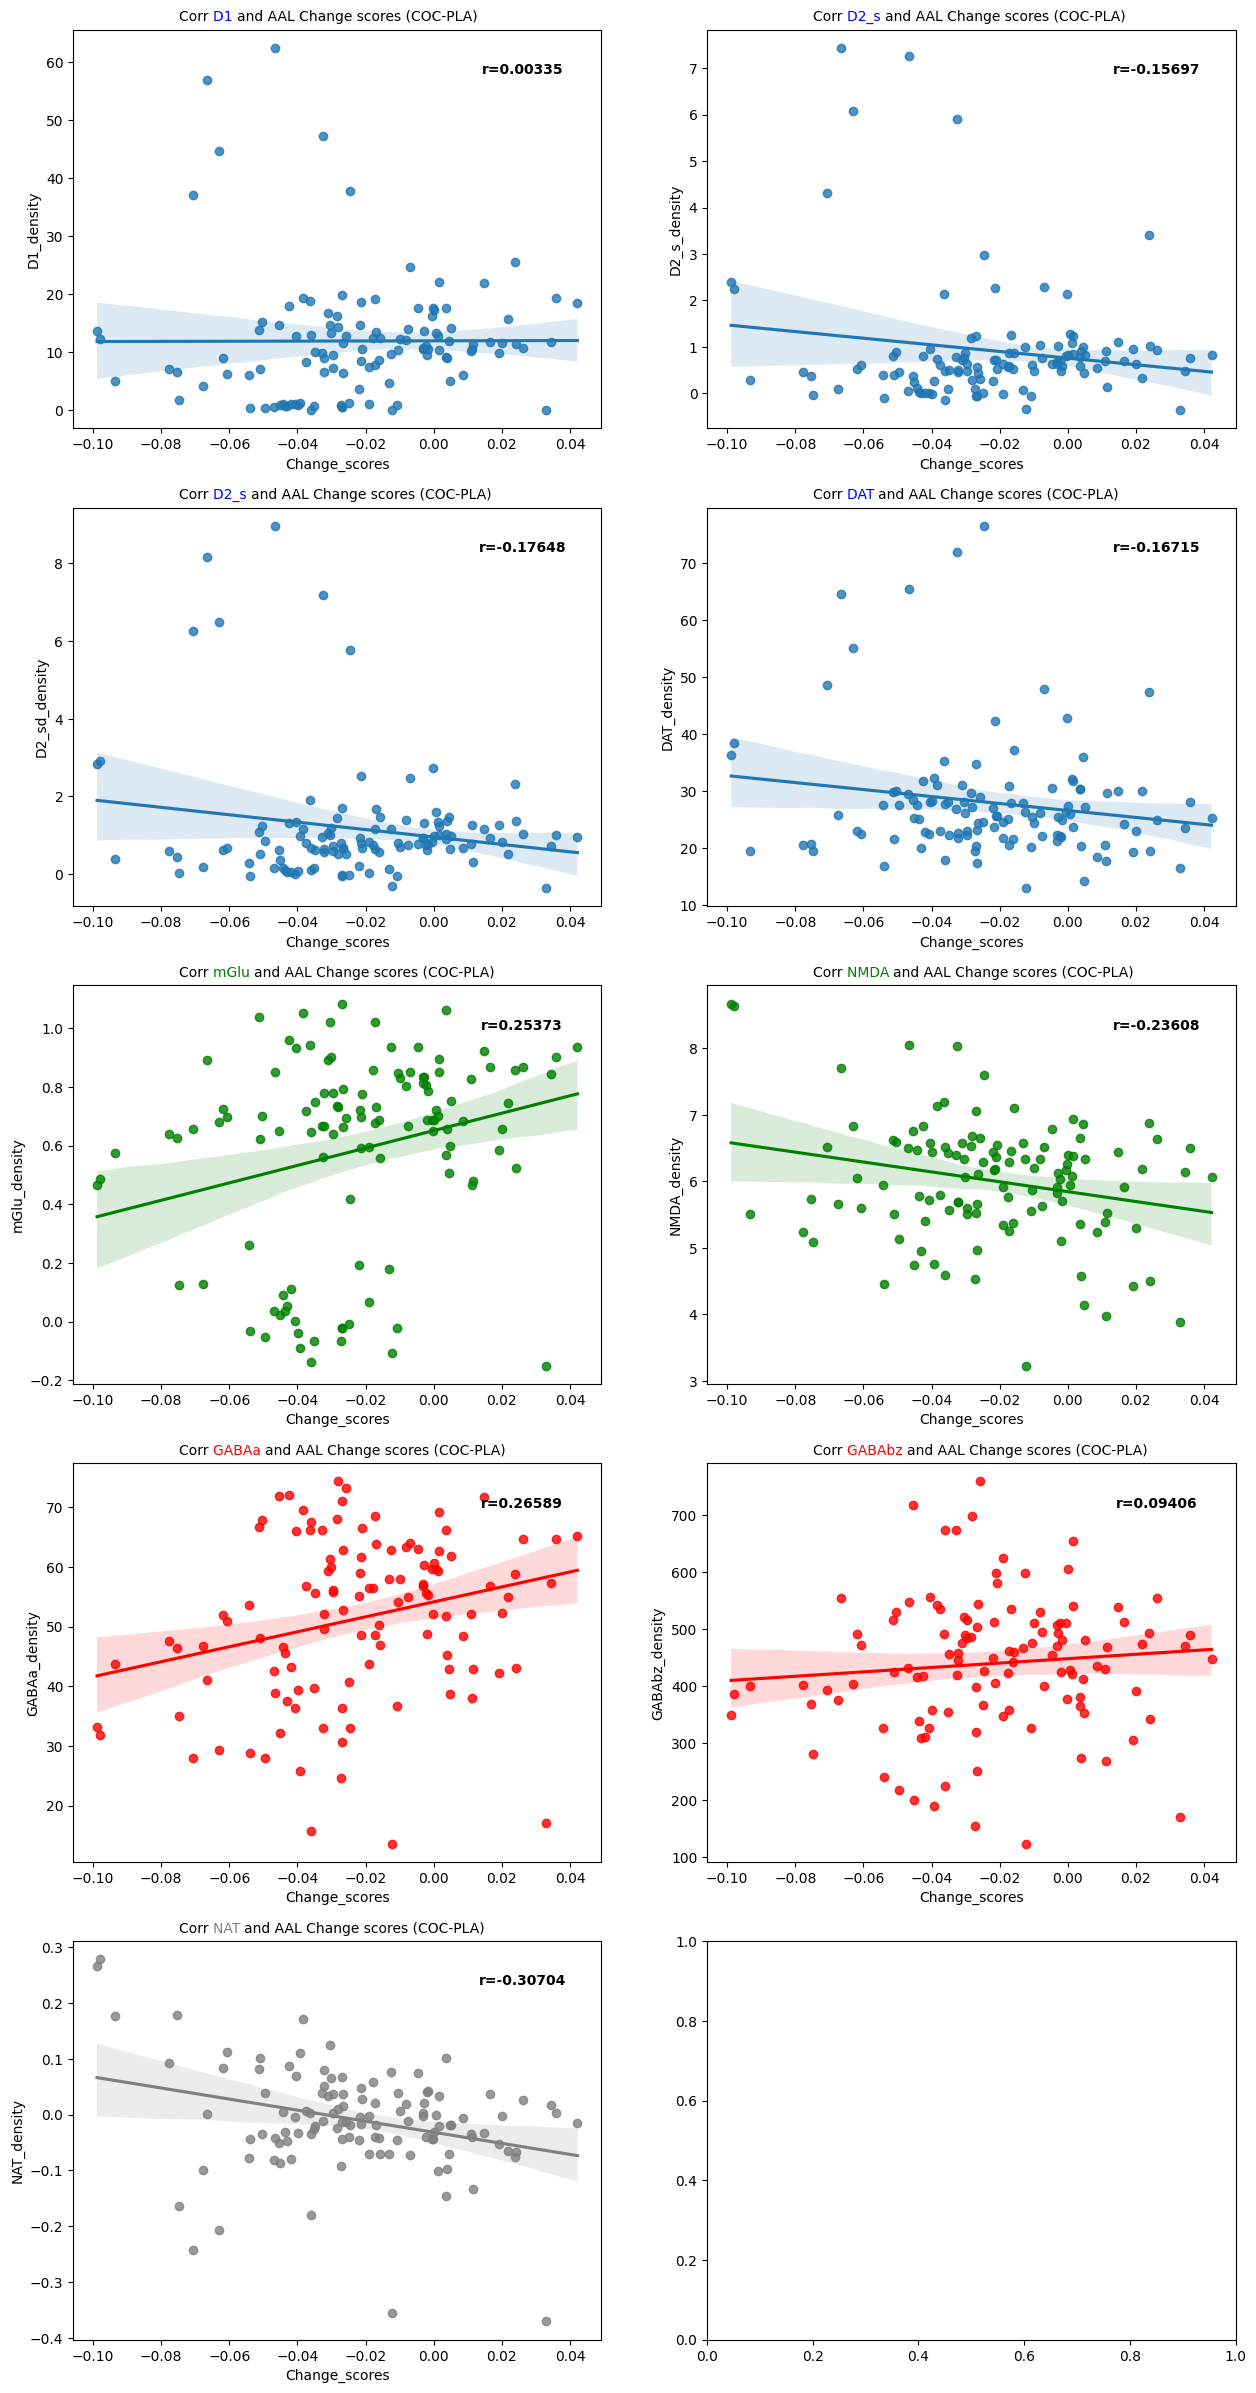

In [36]:
from flexitext import flexitext
import matplotlib as mpl

mpl.rcParams['figure.facecolor'] = 'w'


all_data_AAL = np.array([Change_PC1_AA_mean_scores, D1_to_AAL_mean_scores, D2_smith_to_AAL_mean_scores, D2_sd_to_AAL_mean_scores, DAT_to_AAL_mean_scores,
                        NAT_to_AAL_mean_scores, mGlu_to_AAL_mean_scores, NMDA_to_AAL_mean_scores, GABAa_to_AAL_mean_scores, GABAbz_to_AAL_mean_scores])

Neurotransmitters_AAl_scores = pd.DataFrame(data=all_data_AAL.T, columns=["Change_scores", "D1_density", "D2_s_density", "D2_sd_density", "DAT_density", "NAT_density", 
                                                                          "mGlu_density", "NMDA_density", "GABAa_density", "GABAbz_density"])

fig, ax = plt.subplots(5, 2, figsize=(15, 30))

regplot_D1 = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="D1_density", ax=ax[0, 0])
title1 = "Corr <color:blue>D1 </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title1, va="top", ax=ax[0, 0])
r_value1 = "<weight:bold, size:10>r="+str(round(D1_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value1, ha="center", ax=ax[0, 0])

regplot_D2_s = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="D2_s_density", ax=ax[0, 1])
title2 = "Corr <color:blue>D2_s </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title2, va="top", ax=ax[0, 1])
r_value2 = "<weight:bold, size:10>r="+str(round(D2_smith_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value2, ha="center", ax=ax[0, 1])

regplot_D2_sd = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="D2_sd_density", ax=ax[1, 0])
title3 = "Corr <color:blue>D2_s </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title3, va="top", ax=ax[1, 0])
r_value3 = "<weight:bold, size:10>r="+str(round(D2_sd_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value3, ha="center", ax=ax[1, 0])

regplot_DAT = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="DAT_density", ax=ax[1, 1])
title4 = "Corr <color:blue>DAT </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title4, va="top", ax=ax[1, 1])
r_value4 = "<weight:bold, size:10>r="+str(round(DAT_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value4, ha="center", ax=ax[1, 1])

regplot_mGlu = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="mGlu_density", ax=ax[2, 0], color="green")
title5 = "Corr <color:green>mGlu </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title5, va="top", ax=ax[2, 0])
r_value5 = "<weight:bold, size:10>r="+str(round(mGlu_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value5, ha="center", ax=ax[2, 0])

regplot_NMDA = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="NMDA_density", ax=ax[2, 1], color="green")
title6 = "Corr <color:green>NMDA </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title6, va="top", ax=ax[2, 1])
r_value6 = "<weight:bold, size:10>r="+str(round(NMDA_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value6, ha="center", ax=ax[2, 1])

regplot_mGlu = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="GABAa_density", ax=ax[3, 0], color="red") 
title7 = "Corr <color:red>GABAa </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title7, va="top", ax=ax[3, 0])
r_value7 = "<weight:bold, size:10>r="+str(round(GABAa_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value7, ha="center", ax=ax[3, 0])

regplot_NMDA = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="GABAbz_density", ax=ax[3, 1], color="red")
title8 = "Corr <color:red>GABAbz </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title8, va="top", ax=ax[3, 1])
r_value8 = "<weight:bold, size:10>r="+str(round(GABAbz_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value8, ha="center", ax=ax[3, 1])

regplot_NAT = sns.regplot(data=Neurotransmitters_AAl_scores, x="Change_scores", y="NAT_density", ax=ax[4, 0], color="gray")
title9 = "Corr <color:gray>NAT </>and AAL Change scores (COC-PLA)"
flexitext(0.2, 1.05, title9, va="top", ax=ax[4, 0])
r_value9 = "<weight:bold, size:10>r="+str(round(NAT_AAl_cor[0], 5))+"</>"
flexitext(0.85, 0.9, r_value9, ha="center", ax=ax[4, 0])

plt.show()


## Compare Neurotransmitter Densities to Yeo Atlas (17 Networks) 

## Compare Neurotransmitter Densities to RM Atlas 